# Covariance

Here I compute gaussian theoretical covariances for $\xi(s)$ and $\gamma(\theta)$. To evaluate the integrals I use the `2DFFTLog` described on Fang et al. 2020.

### FFTLog Example: `two_Bessel_binave()`

This function computes equation 19 in https://arxiv.org/pdf/2004.04833.pdf, which is the convariance of projected quantities, $\xi(s), \gamma(\theta), $ ...



#### Code Implementation
The Bessel integrals are related to the Hankel transformations by a change of variables of the legendre polynomial. The function implements the hankel transformation of the power spectrum for 3D with:
```
two_sph_bessel(x1, x2, fx1x2, nu1=1.01, nu2=1.01, N_extrap_low=0, N_extrap_high=0, c_window_width=0.25, N_pad=0)
```

And to have 2D quantities you simply change variables of the bessel functions, $J_n(z) = \sqrt{2 \pi / z} j_{n-1/2} (z) $

```
two_sph_bessel(x1, x2, (fx1x2.T * np.sqrt(x1)).T * np.sqrt(x2), nu1, nu2, N_extrap_low, N_extrap_high, c_window_width, N_pad)
```

where x1 and x2 are two different modes, $k_1, k_2$ and the term fx1x2 is the function $f(k_1, k_2)$. The other parameters are related to the `FFTLog` algorithm.

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from twobessel import *

In [2]:
# load a power spectrum example

k, pk = np.loadtxt('Pk_test', usecols=(0,1), unpack=True)

##### Set quantities: $\ell, f(k)$

In [3]:
# ell = 0 to \xi
ell1 = 0
ell2 = 0
nu = 1.01

dlnk = np.log(k[1]/k[0])
N = k.size

print('number of input data points: '+str(N))


number of input data points: 3000


In [51]:
# start fk1k2
# power spectrum covariance
DL = 200**3
Vsurvey = DL*(5000)*(np.pi/180)**2
Norm = 64*np.pi**3/Vsurvey
pk_cov = pk**1 # check if is power 2 or 1
fk1k2 = Norm*k**3*pk_cov

pk1k2 = np.diag(fk1k2/dlnk)

pk1k2.shape

(3000, 3000)

#### Running the Covariance Code

In [52]:
mytwo_Bessel = two_Bessel(k, k, pk1k2, nu1=nu, nu2=nu, N_extrap_low=0, N_extrap_high=0, c_window_width=0.25, N_pad=0)
t1 = time()
r1, r2, Fr1r2 = mytwo_Bessel.two_Bessel_binave(ell1, ell2, dlnk, dlnk)
t2 = time()
print('time: %fs'%(t2-t1))

3000 3000
(3000, 3000)
3000 3000
time: 0.901337s


In [53]:
dlnk

0.004606705754546073

In [54]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

def get_corrFunc(s, k, pk, ell=0):
    si, xi0 = hankl.P2xi(k, pk, l=ell)
    #xi = np.interp(s, si, xi0)
    return si, xi0

s, xi = get_corrFunc(r1, k, pk)

Using hankel v1.1.0


Testing two_Bessel_binave


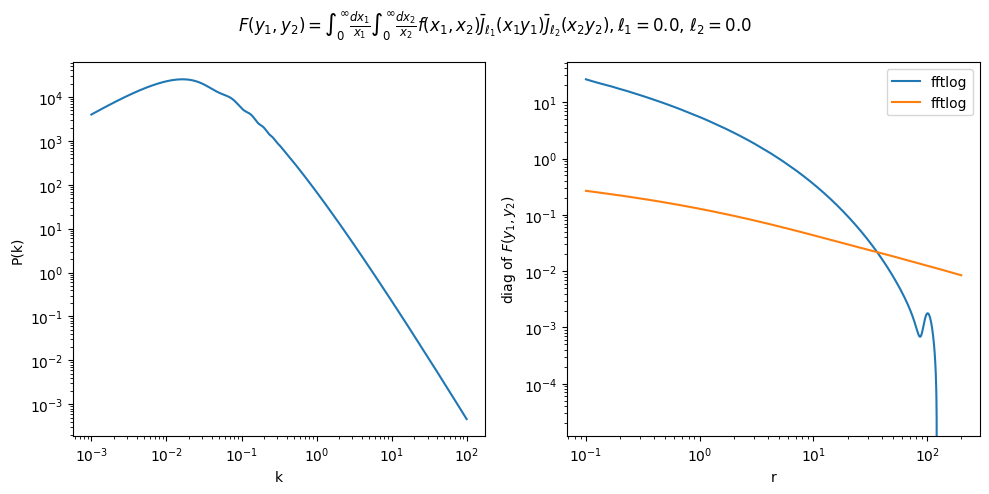

In [55]:
print('Testing two_Bessel_binave')
fig = plt.figure(figsize=(10,5))
fig.suptitle(r'$F(y_1,y_2) = \int_0^\infty \frac{dx_1}{x_1}\int_0^\infty \frac{dx_2}{x_2} f(x_1,x_2)\bar{J}_{\ell_1}(x_1y_1)\bar{J}_{\ell_2}(x_2y_2), \ell_1=$%.1f, $\ell_2=$%.1f'%(ell1,ell2))

ixcut = (k>1e-3)&(k<1e2)

subfig1 = fig.add_subplot(1,2,1)
subfig1.set_xscale('log')
subfig1.set_yscale('log')
subfig1.set_xlabel('k')
subfig1.set_ylabel('P(k)')
subfig1.plot(k[ixcut], pk[ixcut])
plt.tight_layout()

ixcut = (r1>1e-1)&(r1<200)
subfig2 = fig.add_subplot(1,2,2)
# subfig2.set_title(r'$\nu=$%.2f'%(nu))
subfig2.set_xscale('log')
subfig2.set_yscale('log')
subfig2.set_xlabel('r')
subfig2.set_ylabel(r'diag of $F(y_1,y_2)$')
subfig2.plot(r1[ixcut], xi[ixcut], label='fftlog')
subfig2.plot(r1[ixcut], np.sqrt(np.diag(Fr1r2)[ixcut]), label='fftlog')

plt.legend()
plt.tight_layout()



The Fractional error has the shape of JK errors I found using treecorr. Now I just need to get right the normalization factor.

In [56]:
ixcut = np.where((r1>1e-1)&(r1<200))[0]
ixcut2 = np.where((r2>1e-1)&(r2<200))[0]

print(ixcut)
print(ixcut2)

[ 500  501  502 ... 2147 2148 2149]
[ 500  501  502 ... 2147 2148 2149]


/tmp/ipykernel_61333/396122582.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Text(0.5, 1.0, 'Covariance: $\\xi(r)$')

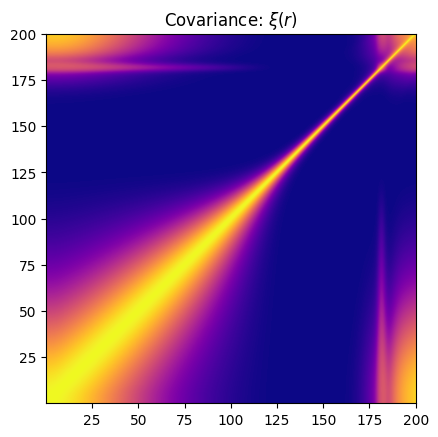

In [57]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage.filters import gaussian_filter

Fr1r2_cut =  Fr1r2[500:2150, 500:2150]
cmap = 'plasma'
vmin, vmax = 0.01, 1.
# plt.figure(figsize=(10,10))
img = plt.imshow(gaussian_filter(np.corrcoef(Fr1r2_cut), 0.1), 
                 origin='lower', extent=[0.1, 200, 0.1,200], norm=PowerNorm(gamma=4, vmin=vmin, vmax=vmax), cmap=cmap)
plt.title(r'Covariance: $\xi(r)$')

## Shear Profile Covariance: $\gamma(\theta)$

The only difference should be the $\ell$ value. I will check this assumption.

In [99]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

omega_m  = cosmo.Om0
h=cosmo.H0.value/100.
const = 1.67e-7 * (omega_m * h**2) # /Mpc^2

def compute_beta(zl, zs, cosmo):
    dl, ds = cosmo.angular_diameter_distance(np.array([zl, zs])).value
    dls = cosmo.angular_diameter_distance_z1z2(zl, zs).value
    return dl, dls/ds

def avg_gamma_t(k, P, l=2, z_lens=0.1, z_source_eff=1., cosmo=cosmo):
    """ Compute the average gamma_t
    
    Formula 12 from Jeong, Komatsu and Jain 2009
    """
    # compute hankel transformation of the matter power spectrum
    r, f = hankl.FFTLog(k, P * k ** 0.5, q=0, mu=l + 0.5)
    
    # gamma_t without the normalization factors
    gmt_wo_norm = f * (2.0 * np.pi) ** (-0.5) * r ** (-1.5)
    
    # compute sigma_crit times rho_0
    ## useful constant (4\pi G\rho_0)/c^2 [1/Mpc^2] value
    const = 1.67e-7 * (cosmo.Om0 * cosmo.h**2)
    
    # beta is dA_lens_source/dA_source
    dA_lens, beta = compute_beta(z_lens, z_source_eff, cosmo)
    
    # final normalization factor
    sigma_crit_rho = const*(1+z_lens)*dA_lens*beta
    
    return r, gmt_wo_norm


In [127]:
mytwo_Bessel = two_Bessel(k, k, pk1k2, nu1=1.5, nu2=1.0, N_extrap_low=0, N_extrap_high=0, c_window_width=0.25, N_pad=0)
t1 = time()
r1, r2, Gr1r2 = mytwo_Bessel.two_Bessel_binave(2, 2, dlnk, dlnk)

t2 = time()
print('time: %fs'%(t2-t1))

3000 3000
(3000, 3000)
3000 3000
time: 1.227835s


In [128]:
s, gt = avg_gamma_t(k, pk, l=2, z_lens=0.1, z_source_eff=1., cosmo=cosmo)

Testing two_Bessel_binave


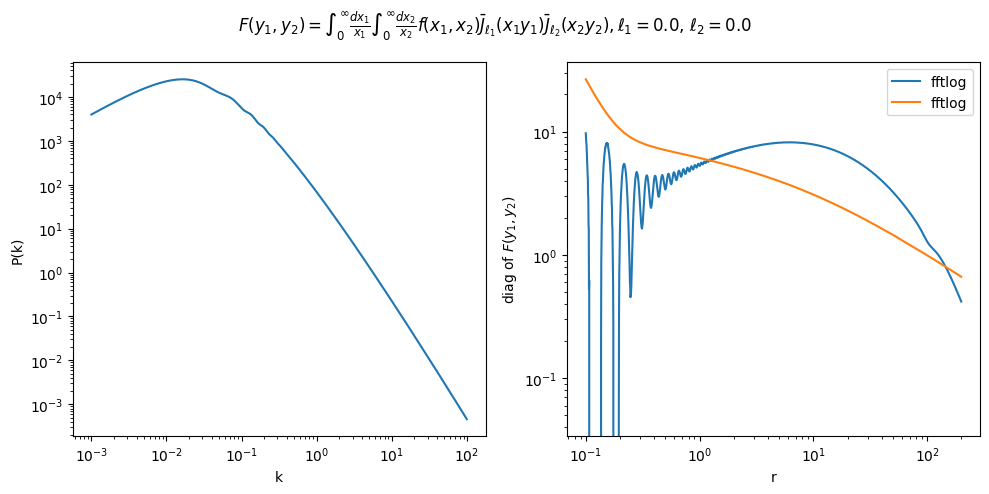

In [129]:
print('Testing two_Bessel_binave')
fig = plt.figure(figsize=(10,5))
fig.suptitle(r'$F(y_1,y_2) = \int_0^\infty \frac{dx_1}{x_1}\int_0^\infty \frac{dx_2}{x_2} f(x_1,x_2)\bar{J}_{\ell_1}(x_1y_1)\bar{J}_{\ell_2}(x_2y_2), \ell_1=$%.1f, $\ell_2=$%.1f'%(ell1,ell2))

ixcut = (k>1e-3)&(k<1e2)

subfig1 = fig.add_subplot(1,2,1)
subfig1.set_xscale('log')
subfig1.set_yscale('log')
subfig1.set_xlabel('k')
subfig1.set_ylabel('P(k)')
subfig1.plot(k[ixcut], pk[ixcut])
plt.tight_layout()

ixcut = (r1>1e-1)&(r1<200)
subfig2 = fig.add_subplot(1,2,2)
# subfig2.set_title(r'$\nu=$%.2f'%(nu))
subfig2.set_xscale('log')
subfig2.set_yscale('log')
subfig2.set_xlabel('r')
subfig2.set_ylabel(r'diag of $F(y_1,y_2)$')
subfig2.plot(r1[ixcut], gt[ixcut], label='fftlog')
subfig2.plot(r1[ixcut], np.sqrt(np.diag(Gr1r2)[ixcut]), label='fftlog')

plt.legend()
plt.tight_layout()



The Fractional error has the shape of JK errors I found using treecorr. Now I just need to get right the normalization factor.

In [130]:
ixcut = np.where((r1>1e-1)&(r1<200))[0]
ixcut2 = np.where((r2>1e-1)&(r2<200))[0]

print(ixcut)
print(ixcut2)

[ 500  501  502 ... 2147 2148 2149]
[ 500  501  502 ... 2147 2148 2149]


/tmp/ipykernel_57399/1189793420.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Text(0.5, 1.0, 'Covariance: $\\gamma(s)$')

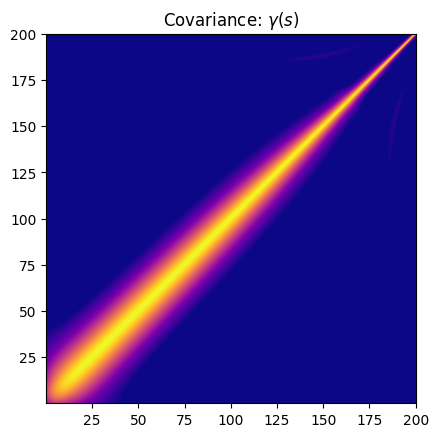

In [131]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage.filters import gaussian_filter

Gr1r2_cut =  Gr1r2[500:2150, 500:2150]
cmap = 'plasma'
vmin, vmax = 0.01, 1.
# plt.figure(figsize=(10,10))
img = plt.imshow(gaussian_filter(np.corrcoef(Gr1r2_cut), 0.1), 
                 origin='lower', extent=[0.1, 200, 0.1,200], norm=PowerNorm(gamma=1, vmin=vmin, vmax=vmax), cmap=cmap)
plt.title(r'Covariance: $\gamma(s)$')